https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

# 前處理
https://www.kaggle.com/abdalazez/predict-future-sales-2020#1.-Data-Cleaning

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import copy
import re
from matplotlib.font_manager import FontProperties

In [2]:
myfont = FontProperties(fname=r'/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/TaipeiSansTCBeta-Regular.ttf')

## 讀取

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/kaggle_data/sales_train.csv')

In [4]:
df_items = pd.read_csv('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/kaggle_data/items.csv')

In [5]:
df_cate = pd.read_csv('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/kaggle_data/item_categories.csv')

In [12]:
df_test = pd.read_csv('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/kaggle_data/test.csv')

In [7]:
df_shop = pd.read_csv('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/kaggle_data/shops.csv')

## 離群值

In [17]:
def plotDots(df):
    length_df = len(df)
    max_df = np.max(df)
    min_df = np.min(df)
    mean_df = np.mean(df)
    std_df = np.std(df)

    plt.figure(figsize=(10,5))

    plt.plot(df,[0]*length_df,'x')
    
    plt.xlabel(f'min {np.round(min_df,decimals=2)} / max {np.round(max_df,decimals=2)} / mean {np.round(mean_df,decimals=2)} / std {np.round(std_df,decimals=2)}',fontproperties=myfont)
    plt.title(df.name)

    print('max',max_df)
    print('min',min_df)
    print('mean',mean_df)
    print('std',std_df)

max 307980.0
min -1.0
mean 890.8532326979881
std 1729.799336113404


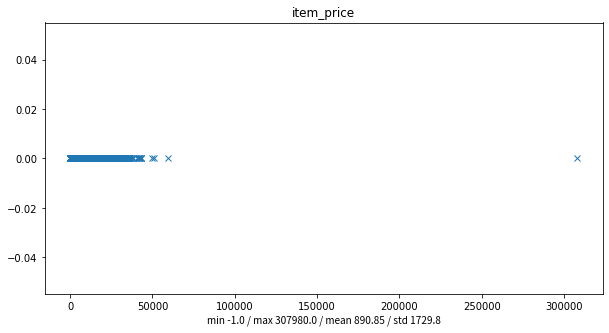

In [18]:
plotDots(df_train['item_price'])

max 2169.0
min -22.0
mean 1.242640885140891
std 2.6188339848894366


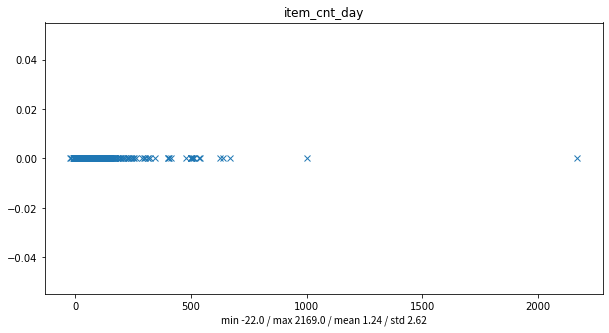

In [19]:
plotDots(df_train['item_cnt_day'])

移除

In [20]:
df_train = df_train[(df_train['item_price'] < 300000 )& (df_train['item_cnt_day'] < 1000)]

In [21]:
df_train = df_train[df_train['item_price'] > 0].reset_index(drop = True)

In [22]:
df_train.loc[df_train['item_cnt_day'] < 1, 'item_cnt_day'] = 0

統計

max 59200.0
min 0.07
mean 890.7495417688747
std 1720.4904827011055


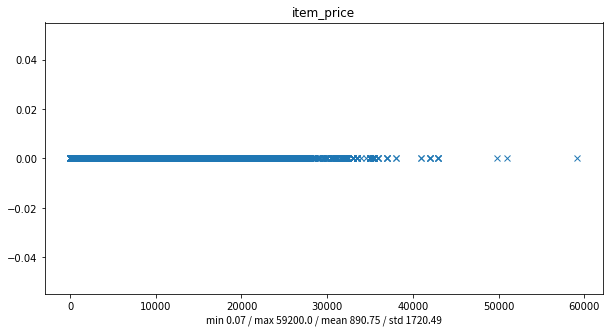

In [23]:
plotDots(df_train['item_price'])

max 669.0
min 0.0
mean 1.2441310764021942
std 2.2155246697539486


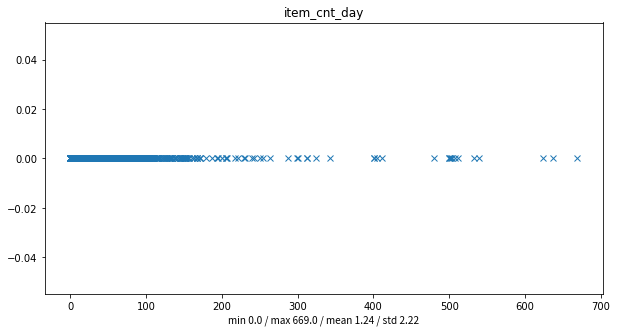

In [24]:
plotDots(df_train['item_cnt_day'])

## 商店 DataFrame

商店整理

相同店名

In [25]:
same_shopId = [[0,57],[1,58],[10,11]]

In [26]:
for pair in same_shopId:
    df_train.loc[df_train['shop_id'] == pair[0], 'shop_id'] = pair[1]
    df_test.loc[df_test['shop_id'] == pair[0], 'shop_id'] = pair[1]

In [27]:
df_shop["city"] = df_shop['shop_name'].str.split(' ').map( lambda x: ' '.join(x[0:-2]) )
df_shop["category"] = df_shop['shop_name'].str.split(' ').map( lambda x: x[-2] )

In [28]:
df_shop["city"] = df_shop["city"].apply( lambda x: re.sub('[!]', '', x))

商店類型整理

Text(0, 0.5, '數量')

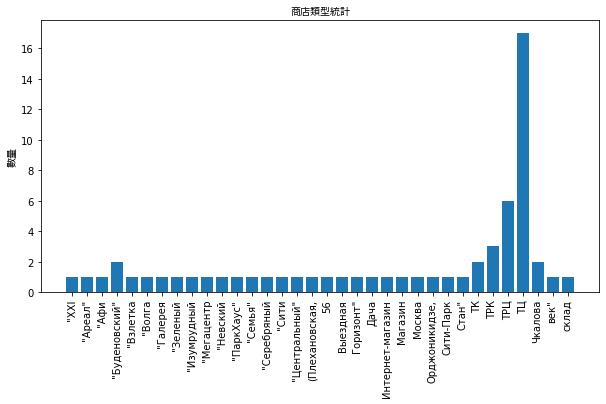

In [29]:
values, counts = np.unique(df_shop['category'], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(range(len(values)),counts)
plt.xticks(ticks=range(len(values)),labels=values, rotation=90)
plt.title('商店類型統計',fontproperties=myfont)
plt.ylabel('數量',fontproperties=myfont)

Text(0, 0.5, '數量')

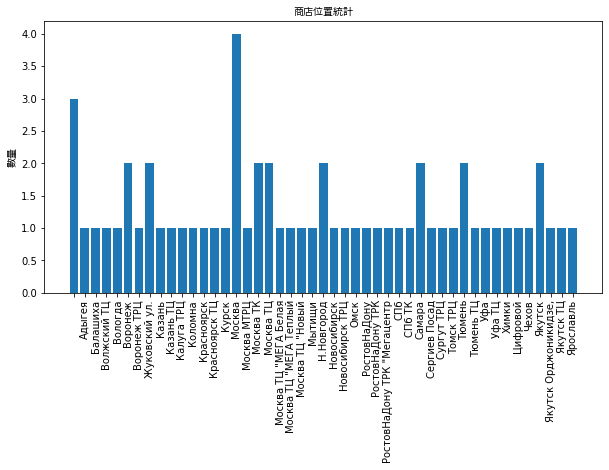

In [30]:
values, counts = np.unique(df_shop['city'], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(range(len(values)),counts)
plt.xticks(ticks=range(len(values)),labels=values, rotation=90)
plt.title('商店位置統計',fontproperties=myfont)
plt.ylabel('數量',fontproperties=myfont)

In [31]:
category = []
for cat in df_shop['category'].unique():
    if len(df_shop[df_shop['category'] == cat]) >= 5:
        category.append(cat)
df_shop['category'] = df_shop['category'].apply( lambda x: x if (x in category) else "other" )

Text(0, 0.5, '數量')

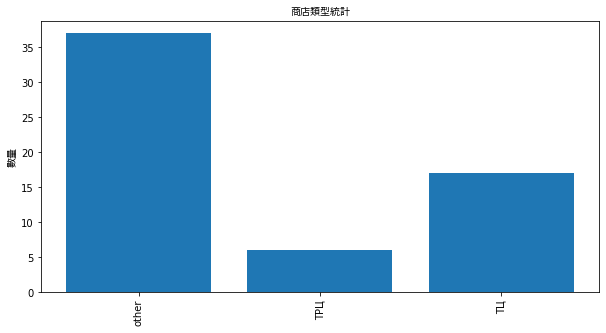

In [32]:
values, counts = np.unique(df_shop['category'], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(range(len(values)),counts)
plt.xticks(ticks=range(len(values)),labels=values, rotation=90)
plt.title('商店類型統計',fontproperties=myfont)
plt.ylabel('數量',fontproperties=myfont)

將文字label換成ID

In [33]:
_, df_shop['shopcategory_id'] = np.unique(df_shop['category'], return_inverse=True)
_, df_shop['shop_city_id'] = np.unique(df_shop['city'], return_inverse=True)

df_shop = df_shop[["shop_id", "shopcategory_id", "shop_city_id"]]

更改資料型別

In [34]:
for key in df_shop.keys():
    df_shop[key] = df_shop[key].astype(np.int8)

## 商品類別 DataFrame

格式：類型1 - 類型2

取得 **1st 類別** 和 **2nd 類別**

In [35]:
df_cate['cate_type'] = df_cate['item_category_name'].apply( lambda x: re.split(' - ', x)[0] ).astype(str)
df_cate['cate_subtype'] = df_cate['item_category_name'].apply( lambda x: re.split(' - ', x)[-1] ).astype(str)

Text(0, 0.5, '數量')

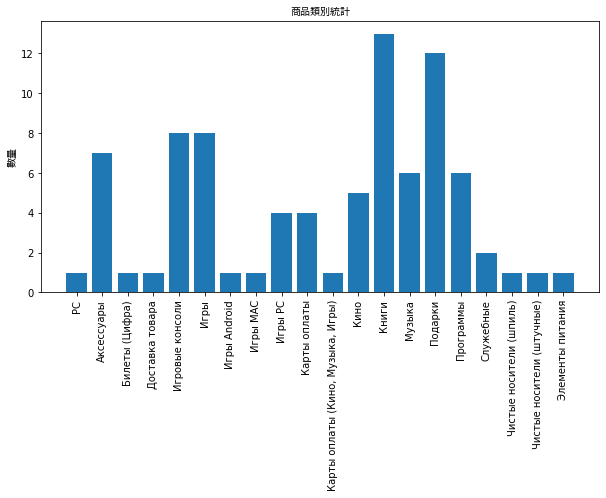

In [36]:
values, counts = np.unique(df_cate['cate_type'], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(range(len(values)),counts)
plt.xticks(ticks=range(len(values)),labels=values, rotation=90)
plt.title('商品類別統計',fontproperties=myfont)
plt.ylabel('數量',fontproperties=myfont)

In [37]:
category = []
for cat in df_cate['cate_type'].unique():
    if len(df_cate[df_cate['cate_type'] == cat]) >= 5: 
        category.append( cat )
df_cate['cate_type'] = df_cate['cate_type'].apply(lambda x: x if (x in category) else 'etc')

Text(0, 0.5, '數量')

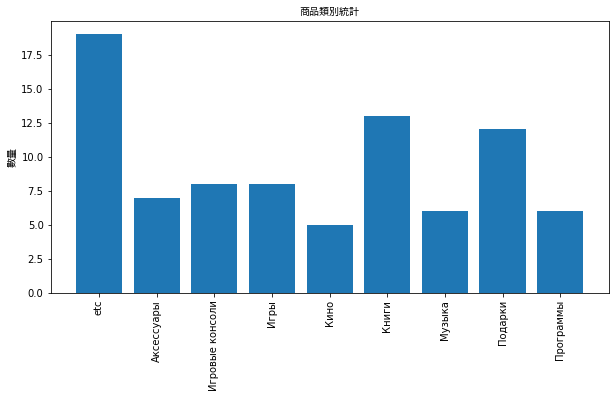

In [38]:
values, counts = np.unique(df_cate['cate_type'], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(range(len(values)),counts)
plt.xticks(ticks=range(len(values)),labels=values, rotation=90)
plt.title('商品類別統計',fontproperties=myfont)
plt.ylabel('數量',fontproperties=myfont)

將 label轉換為code

In [39]:
_, df_cate['cate_type_id'] = np.unique(df_cate['cate_type'], return_inverse=True)
_, df_cate['cate_subtype_id'] = np.unique(df_cate['cate_subtype'], return_inverse=True)

In [40]:
df_cate = df_cate[['item_category_id','cate_type_id','cate_subtype_id']]

更改資料型別

In [41]:
for key in df_cate.keys():
    df_cate[key] = df_cate[key].astype(np.int8)

## 商品 DataFrame

In [42]:
df_items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [43]:
def splitNameType1(x):
    result = re.findall(r'\(.*\)', x)
    for index in range(len(result)):
        result[index] = re.sub(',', '', result[index][1:-1])   

    if len(result) == 0:
        return x

    return ' '.join(result)

In [44]:
def splitNameType2(x):
    result = re.findall(r'\[.*\]', x)
    for index in range(len(result)):
        result[index] = re.sub(',', '', result[index][1:-1])   

    if len(result) == 0:
        return x

    return ' '.join(result)

In [45]:
df_items['item_type_1'] = df_items['item_name'].apply(lambda x: splitNameType1(x)) 
df_items['item_type_2'] = df_items['item_name'].apply(lambda x: splitNameType2(x)) 

In [46]:
df_items['item_type_1'] = df_items['item_type_1'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
df_items['item_type_2'] = df_items['item_type_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

In [47]:
def cleanSmalltypes(df, col):
    item_type = []
    for item in df[col].unique():
        if len(df[df[col] == item]) >= 40: 
            item_type.append( item )
    return df[col].apply(lambda x: x if (x in item_type) else 'other')


df_items['item_type_1'] = cleanSmalltypes(df_items, 'item_type_1')
df_items['item_type_2'] = cleanSmalltypes(df_items, 'item_type_2')

Text(0, 0.5, '數量')

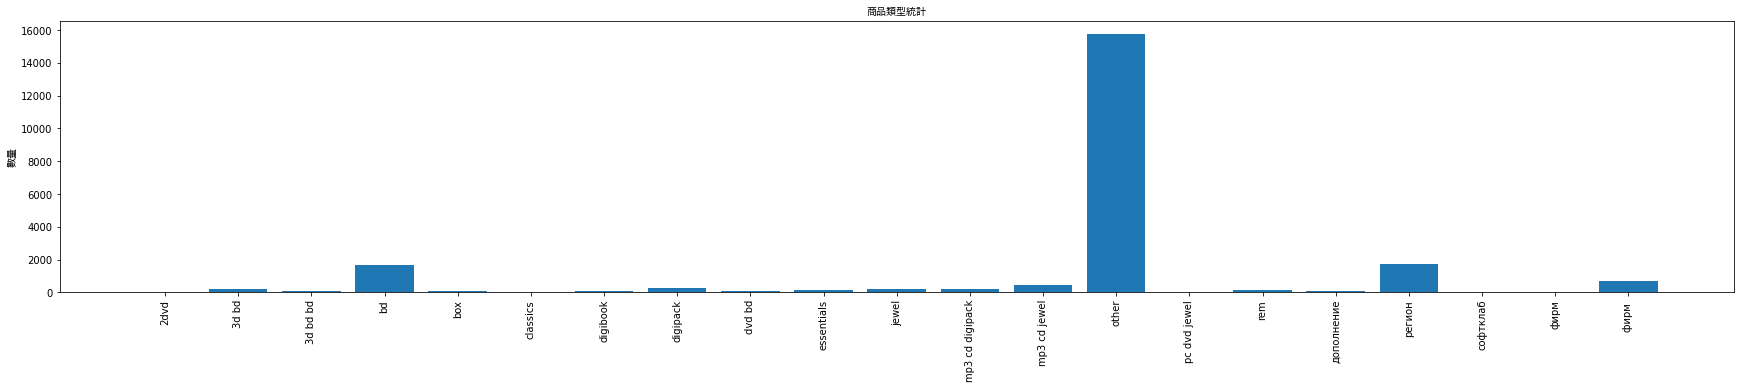

In [48]:
values, counts = np.unique(df_items['item_type_1'], return_counts=True)

plt.figure(figsize=(30,5))
plt.bar(range(len(values)),counts)
plt.xticks(ticks=range(len(values)),labels=values, rotation=90)
plt.title('商品類型統計',fontproperties=myfont)
plt.ylabel('數量',fontproperties=myfont)

In [49]:
_, df_items['item_type_1_id'] = np.unique(df_items['item_type_1'], return_inverse=True)
_, df_items['item_type_2_id'] = np.unique(df_items['item_type_2'], return_inverse=True)

In [50]:
df_items = df_items[['item_id','item_category_id','item_type_1_id','item_type_2_id']]

更改資料型別

In [51]:
for key in df_items.keys():
    df_items[key] = df_items[key].astype(np.int16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 建立總資料集

## 訓練資料集

In [ ]:
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales['shop_id'].unique(), sales['item_id'].unique() ) ), dtype = np.int16) )

In [ ]:
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

### 將每日銷售量轉換為每月統計

In [ ]:
group = df_train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)

### 新增預測資料

產生預測資料

In [ ]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

合併

In [ ]:
matrix = pd.concat([matrix, df_test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)

In [ ]:
matrix.fillna( 0, inplace = True )

### 合併 **shop_id** / **item_id** / **cate_id**

In [ ]:
matrix = pd.merge( matrix, df_shop, on = ["shop_id"], how = "left" )

In [ ]:
matrix = pd.merge(matrix, df_items, on = ["item_id"], how = "left")

In [ ]:
matrix = pd.merge( matrix, df_cate, on = ["item_category_id"], how = "left" )

### 加上銷售量延遲

In [ ]:
shop_item_pair_count = len(list(product( sales['shop_id'].unique(), sales['item_id'].unique())))

In [ ]:
lags = [1,2,3]
col = 'item_cnt_month'

for i in lags:
    matrix[f'{col}_lag_{i}'] = matrix[col].shift(shop_item_pair_count * i, axis = 0)

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shopcategory_id,shop_city_id,item_category_id,item_type_1_id,item_type_2_id,cate_type_id,cate_subtype_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,2,19,0.0,2,1,40,13,0,4,6,NaN,NaN,NaN
1,0,2,27,1.0,2,1,19,13,8,3,12,NaN,NaN,NaN
2,0,2,28,0.0,2,1,30,13,13,0,57,NaN,NaN,NaN
3,0,2,29,0.0,2,1,23,13,15,3,18,NaN,NaN,NaN
4,0,2,32,0.0,2,1,40,13,0,4,6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,2,32,55,13,0,6,4,0.0,0.0,0.0
11128000,34,45,16188,0.0,2,32,64,13,0,7,44,0.0,0.0,0.0
11128001,34,45,15757,0.0,2,32,55,13,0,6,4,0.0,0.0,0.0
11128002,34,45,19648,0.0,2,32,40,17,0,4,6,0.0,0.0,0.0


### 加上銷售量月平均

計算月平均

In [ ]:
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace = True)

In [ ]:
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)

延遲

In [ ]:
lags = [1]
col = 'date_avg_item_cnt'

for i in lags:
    matrix[f'{col}_lag_{i}'] = matrix[col].shift(shop_item_pair_count * i, axis = 0)

In [ ]:
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )

### 日期

In [ ]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

### 價格(目前是照抄)

In [ ]:
group = df_train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = df_train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)

##
lags = [1, 2, 3]
col = 'date_item_avg_item_price'
for i in lags:
    matrix[f'{col}_lag_{i}'] = matrix[col].shift(shop_item_pair_count * i, axis = 0)
##

for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)

### 統計

In [ ]:
matrix.fillna( 0, inplace = True )

In [ ]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,19.0,27.0,28.0,29.0,32.0
item_cnt_month,0.0,1.0,0.0,0.0,0.0
shopcategory_id,2.0,2.0,2.0,2.0,2.0
shop_city_id,1.0,1.0,1.0,1.0,1.0
item_category_id,40.0,19.0,30.0,23.0,40.0
item_type_1_id,13.0,13.0,13.0,13.0,13.0
item_type_2_id,0.0,8.0,13.0,15.0,0.0
cate_type_id,4.0,3.0,0.0,3.0,4.0


# Model

## light GBM

### 製作訓練集

In [ ]:
data = matrix.copy()

In [3]:
data = pd.read_hdf('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/preprocessData.h5')

In [4]:
X_train = data[data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data['date_block_num'] < 33]['item_cnt_month']
X_valid = data[data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data['date_block_num'] == 33]['item_cnt_month']
X_test = data[data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

### 訓練

In [5]:
!pip install lightgbm

In [6]:
import lightgbm as lgb

In [7]:
num_round = 50
param = {'max_depth': 10, 'objective': 'regression', 'seed': 42, 'n_estimators':1000, 'min_child_weight':0.5, 'colsample_bytree':0.8, 'subsample':0.8,
    'eta':0.1, 'early_stopping_rounds':20}

In [8]:
train_data = lgb.Dataset(X_train, label=Y_train)
validation_data = lgb.Dataset(X_valid, label=Y_valid)

In [9]:
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 6.69115
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 6.06491
[3]	valid_0's l2: 5.59114
[4]	valid_0's l2: 5.24315
[5]	valid_0's l2: 5.02388
[6]	valid_0's l2: 4.85378
[7]	valid_0's l2: 4.75043
[8]	valid_0's l2: 4.66957
[9]	valid_0's l2: 4.5507
[10]	valid_0's l2: 4.4253
[11]	valid_0's l2: 4.3838
[12]	valid_0's l2: 4.22404
[13]	valid_0's l2: 4.26076
[14]	valid_0's l2: 4.18513
[15]	valid_0's l2: 4.21932
[16]	valid_0's l2: 4.2179
[17]	valid_0's l2: 4.23441
[18]	valid_0's l2: 4.2186
[19]	valid_0's l2: 4.21859
[20]	valid_0's l2: 4.24803
[21]	valid_0's l2: 4.32717
[22]	valid_0's l2: 4.4351
[23]	valid_0's l2: 4.40525
[24]	valid_0's l2: 4.39133
[25]	valid_0's l2: 4.42734
[26]	valid_0's l2: 4.42694
[27]	valid_0's l2: 4.43176
[28]	valid_0's l2: 4.48093
[29]	valid_0's l2: 4.49375
[30]	valid_0's l2: 4.52626
[31]	valid_0's l2: 4.54336
[32]	valid_0's l2: 4.56167
[33]	valid_0's l2: 4.56908
[34]	valid_0's l2: 4.59103
Early stopping, best iteration is:


In [10]:
ypred = bst.predict(X_test)

In [13]:
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": ypred
})
submission.to_csv('lightGBM_clean_submit.csv', index=False)

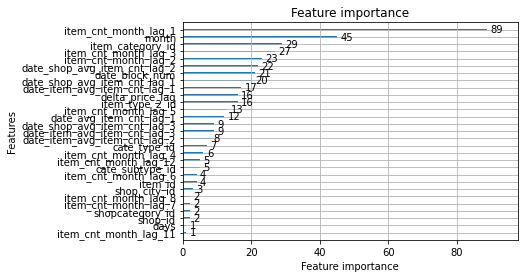

In [14]:
lgb.plot_importance(bst)

## LSTM

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

### 製作訓練集

In [10]:
data = np.load('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/inputs.npz')

train_x = (data['train_x_emb'], data['train_x_other'], data['train_x_time'], data['train_x_cnt'])
train_y = data['train_y']

test_x = (data['test_x_emb'], data['test_x_other'], data['test_x_time'], data['test_x_cnt'])

### 訓練

In [11]:
class predictModel(keras.Model):
    def __init__(self, emb_feature_inputDim: list, other_feature_cnt: int, time_feature_cnt: int):
        super(predictModel, self).__init__()

        self.emb_layers = list()
        for n, dim in enumerate(emb_feature_inputDim):
            layer = keras.layers.Embedding(
                input_dim=dim, output_dim=10, input_length=1)
            self.emb_layers.append(layer)

        self.other_layers = list()
        for n in range(other_feature_cnt):
            layer = keras.layers.Dense(10)
            self.other_layers.append(layer)

        self.time_layers = list()
        for n in range(time_feature_cnt):
            layer = keras.layers.LSTM(20)
            self.time_layers.append(layer)

        self.cnt_layer = keras.layers.LSTM(20)

        self.denses = keras.Sequential([
            keras.layers.Dense(256, activation='tanh'),
            keras.layers.Dense(128, activation='tanh'),
            keras.layers.Dense(64, activation='tanh'),
            keras.layers.Dense(1),
        ])

    def call(self, inputs):

        emb_features, other_features, time_features, cnt_features = inputs

        emb_features = tf.split(emb_features, num_or_size_splits=[
                                1]*emb_features.shape[-1], axis=-1)
        for n, layer in enumerate(self.emb_layers):
            emb_features[n] = layer(emb_features[n])

        other_features = tf.split(other_features, num_or_size_splits=[
                                  1]*other_features.shape[-1], axis=-1)
        for n, layer in enumerate(self.other_layers):
            other_features[n] = tf.expand_dims(
                layer(other_features[n]), axis=1)

        time_features = tf.split(time_features, num_or_size_splits=[
                                 1]*time_features.shape[-1], axis=-1)
        for n, layer in enumerate(self.time_layers):
            time_features[n] = tf.expand_dims(layer(time_features[n]), axis=1)

        cnt_features = tf.expand_dims(self.cnt_layer(cnt_features), axis=1)

        x = tf.concat(emb_features + other_features + time_features, axis=-1)
        x = tf.concat((x, cnt_features), axis=-1)

        x = tf.squeeze(x, axis=1)

        x = self.denses(x)

        return x

In [12]:
model = predictModel(emb_feature_inputDim= 1 + np.max(train_x[0], axis=0), other_feature_cnt=train_x[1].shape[-1], time_feature_cnt=train_x[2].shape[-1])

model.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError())

In [14]:
model.fit(x=train_x, y=train_y, batch_size=2048, epochs=20, verbose=1)

Epoch 1/20
5330/5330 [==============================] - 72s 13ms/step - loss: 4.1207
Epoch 2/20
5330/5330 [==============================] - 72s 13ms/step - loss: 3.9429
Epoch 3/20
5330/5330 [==============================] - 72s 14ms/step - loss: 3.8309
Epoch 4/20
5330/5330 [==============================] - 74s 14ms/step - loss: 3.7429
Epoch 5/20
5330/5330 [==============================] - 72s 13ms/step - loss: 3.5305
Epoch 6/20
5330/5330 [==============================] - 72s 14ms/step - loss: 3.4486
Epoch 7/20
5330/5330 [==============================] - 72s 14ms/step - loss: 3.3835
Epoch 8/20
5330/5330 [==============================] - 72s 13ms/step - loss: 3.2538
Epoch 9/20
5330/5330 [==============================] - 71s 13ms/step - loss: 3.1902
Epoch 10/20
5330/5330 [==============================] - 71s 13ms/step - loss: 3.1625
Epoch 11/20
5330/5330 [==============================] - 71s 13ms/step - loss: 3.0123
Epoch 12/20
5330/5330 [==============================] - 71s 13

In [15]:
model.save_weights('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/model_weight.h5')

### 預測

In [16]:
model = predictModel(emb_feature_inputDim= 1 + np.max(train_x[0], axis=0), other_feature_cnt=train_x[1].shape[-1], time_feature_cnt=train_x[2].shape[-1])
zeros = [np.zeros_like(train_x[i][:1]) for i in range(len(train_x))]
model(zeros)
model.load_weights('/content/drive/MyDrive/課程相關/109-2/資料科學與人工智慧競技/HW4/model_weight.h5')

In [17]:
pred_y = model.predict(x=test_x, batch_size=1024, verbose=0)

In [18]:
pred_y = pred_y.flatten()

submission = pd.DataFrame({
    'ID': df_test.index, 
    'item_cnt_month': pred_y
})
submission.to_csv('LSTM_clean_submit.csv', index=False)